# 기본 세팅

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from shapely.geometry import box
import matplotlib.pyplot as plt
import seaborn as sns



# 종속변수 설계
- 'F_SHIM', 'F_AVR_HGT', 'F_AREA', 'F_TIME' 를 모두 고려
- PCA를 통한 가중치로 종속변수 설계 고도화

In [ ]:
# Load the flood data
flood = gpd.read_file("/content/drive/MyDrive/공모전_시도/DAB 경영/서울시 침수 흔적도/서울시_2022.shp")

In [ ]:
flood.head()

,OBJECTID,GU_NAM,F_SHIM,F_DISA_NM,F_AVR_HGT,F_AREA,ADM_CD,F_SAT_YMD,F_END_YMD,F_SAT_TM,F_END_TM,F_RSN_DTL,F_ZONE_NM,INV_YR,F_YR,TYPE,geometry
0,275,강북구,0.02,2022년 8.8 ~17. 호우,114.53,3876.0,1130510400,20220808,20220808,18,23,내수침수,서울특별시 강북구 우이동 296-1,2022,2022,주택,"POLYGON ((956425.127 1963792.044, 956424.885 1..."
1,223,강북구,0.02,2022년 8.8 ~17. 호우,118.05,2188.0,1130510400,20220808,20220808,18,23,내수침수,서울특별시 강북구 우이동 299-2,2022,2022,주택,"POLYGON ((956590.641 1963700.111, 956574.753 1..."
2,246,강북구,0.02,2022년 8.8 ~17. 호우,129.55,45287.0,1130510400,20220808,20220808,18,23,내수침수,서울특별시 강북구 우이동 산8-15,2022,2022,주택,"POLYGON ((956383.28 1963392.863, 956473.946 19..."
3,4253,영등포구,0.30,2022년 8.8 ~17. 호우,10.18,53.0,1156010400,20220808,20220810,20,24,내수침수,서울특별시 영등포구 영등포동3가 13-7,2022,2022,상가,"POLYGON ((947842.214 1946702.946, 947843.231 1..."
4,301,강북구,0.02,2022년 8.8 ~17. 호우,75.48,105.0,1130510100,20220808,20220808,18,23,내수침수,서울특별시 강북구 미아동 258-241,2022,2022,주택,"POLYGON ((958804.353 1958357.277, 958809.826 1..."


In [ ]:
# Calculate F_TIME
flood['F_TIME'] = pd.to_numeric(flood['F_END_TM']) - pd.to_numeric(flood['F_SAT_TM'])

# Normalize the features
scaler = StandardScaler()
flood_normalized = flood.copy()
flood_normalized[['F_SHIM', 'F_AVR_HGT', 'F_AREA', 'F_TIME']] = scaler.fit_transform(
    flood[['F_SHIM', 'F_AVR_HGT', 'F_AREA', 'F_TIME']]
)

# Apply PCA
pca = PCA(n_components=1)
flood_normalized['PC1'] = pca.fit_transform(flood_normalized[['F_SHIM', 'F_AVR_HGT', 'F_AREA', 'F_TIME']])
loadings = pca.components_

# Weights for the first principal component
weights = loadings[0]

# Filter for 영등포구
flood_ydp = flood[flood['GU_NAM'] == "영등포구"]

In [ ]:
loadings[0]

array([-0.65847304,  0.31533473, -0.16492427,  0.66315703])

In [ ]:
flood_ydp.head()

,OBJECTID,GU_NAM,F_SHIM,F_DISA_NM,F_AVR_HGT,F_AREA,ADM_CD,F_SAT_YMD,F_END_YMD,F_SAT_TM,F_END_TM,F_RSN_DTL,F_ZONE_NM,INV_YR,F_YR,TYPE,geometry,F_TIME
3,4253,영등포구,0.3,2022년 8.8 ~17. 호우,10.18,53.00,1156010400,20220808,20220810,20,24,내수침수,서울특별시 영등포구 영등포동3가 13-7,2022,2022,상가,"POLYGON ((947842.214 1946702.946, 947843.231 1...",4
7,4692,영등포구,0.3,2022년 8.8 ~17. 호우,14.70,306.45,1156013300,20220808,20220810,20,24,내수침수,서울특별시 영등포구대림동 951-3,2022,2022,주택,"POLYGON ((947780.327 1943886.278, 947779.63 19...",4
8,4693,영등포구,0.3,2022년 8.8 ~17. 호우,14.70,356.66,1156013300,20220808,20220810,20,24,내수침수,서울특별시 영등포구대림동 952-7,2022,2022,주택,"POLYGON ((947755.138 1943823.946, 947743.289 1...",4
9,4694,영등포구,0.3,2022년 8.8 ~17. 호우,14.70,986.23,1156013300,20220808,20220810,20,24,내수침수,서울특별시 영등포구대림동 951-4,2022,2022,주택,"POLYGON ((947766.737 1943967.461, 947767.931 1...",4
10,4695,영등포구,0.3,2022년 8.8 ~17. 호우,14.70,766.25,1156013300,20220808,20220810,20,24,내수침수,서울특별시 영등포구대림동 952-6,2022,2022,주택,"POLYGON ((947742.387 1943832.424, 947730.149 1...",4


In [ ]:
# Create a grid
minx, miny, maxx, maxy = flood_ydp.total_bounds #여기서 bounds를 flood_ydp로 지정해줘서 뒤에 데이터를 서울로 가지고 와도 영등포의 네모에 맞게 해준다!!! 대신 그 모양대로 나오진 않아서 하고 싶으면 경계를 따야 할 듯.
cell_size = 200  # 200x200 meter cells
grid_cells = []
for x0 in np.arange(minx, maxx, cell_size):
    for y0 in np.arange(miny, maxy, cell_size):
        x1 = x0 + cell_size
        y1 = y0 + cell_size
        grid_cells.append(box(x0, y0, x1, y1))
grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=flood_ydp.crs)
grid['grid_id'] = range(1, len(grid) + 1)

# Spatial join flood data with the grid
flood_ydp_grid = gpd.sjoin(flood_ydp, grid, how="left", predicate="intersects")

# Calculate the flood index for each grid cell
flood_ydp_ind = flood_ydp_grid.groupby('grid_id').agg(
    F_SHIM=('F_SHIM', 'mean'),
    F_AVR_HGT=('F_AVR_HGT', 'mean'),
    F_AREA=('F_AREA', 'sum'),
    F_TIME=('F_TIME', 'mean')
).reset_index()

flood_ydp_ind['flood_index'] = -(weights[0] * flood_ydp_ind['F_SHIM'] +
                                weights[1] * flood_ydp_ind['F_AVR_HGT'] +
                                weights[2] * flood_ydp_ind['F_AREA'] +
                                weights[3] * flood_ydp_ind['F_TIME'])

In [ ]:
grid

,geometry,grid_id
0,"POLYGON ((945654.346 1943029.538, 945654.346 1...",1
1,"POLYGON ((945654.346 1943229.538, 945654.346 1...",2
2,"POLYGON ((945654.346 1943429.538, 945654.346 1...",3
3,"POLYGON ((945654.346 1943629.538, 945654.346 1...",4
4,"POLYGON ((945654.346 1943829.538, 945654.346 1...",5
...,...,...
801,"POLYGON ((950654.346 1948229.538, 950654.346 1...",802
802,"POLYGON ((950654.346 1948429.538, 950654.346 1...",803
803,"POLYGON ((950654.346 1948629.538, 950654.346 1...",804
804,"POLYGON ((950654.346 1948829.538, 950654.346 1...",805


In [ ]:
flood_ydp_grid.head()

,OBJECTID,GU_NAM,F_SHIM,F_DISA_NM,F_AVR_HGT,F_AREA,ADM_CD,F_SAT_YMD,F_END_YMD,F_SAT_TM,F_END_TM,F_RSN_DTL,F_ZONE_NM,INV_YR,F_YR,TYPE,geometry,F_TIME,index_right,grid_id
3,4253,영등포구,0.3,2022년 8.8 ~17. 호우,10.18,53.00,1156010400,20220808,20220810,20,24,내수침수,서울특별시 영등포구 영등포동3가 13-7,2022,2022,상가,"POLYGON ((947842.214 1946702.946, 947843.231 1...",4,390,391
3,4253,영등포구,0.3,2022년 8.8 ~17. 호우,10.18,53.00,1156010400,20220808,20220810,20,24,내수침수,서울특별시 영등포구 영등포동3가 13-7,2022,2022,상가,"POLYGON ((947842.214 1946702.946, 947843.231 1...",4,359,360
7,4692,영등포구,0.3,2022년 8.8 ~17. 호우,14.70,306.45,1156013300,20220808,20220810,20,24,내수침수,서울특별시 영등포구대림동 951-3,2022,2022,주택,"POLYGON ((947780.327 1943886.278, 947779.63 19...",4,345,346
8,4693,영등포구,0.3,2022년 8.8 ~17. 호우,14.70,356.66,1156013300,20220808,20220810,20,24,내수침수,서울특별시 영등포구대림동 952-7,2022,2022,주택,"POLYGON ((947755.138 1943823.946, 947743.289 1...",4,344,345
8,4693,영등포구,0.3,2022년 8.8 ~17. 호우,14.70,356.66,1156013300,20220808,20220810,20,24,내수침수,서울특별시 영등포구대림동 952-7,2022,2022,주택,"POLYGON ((947755.138 1943823.946, 947743.289 1...",4,345,346


In [ ]:
flood_ydp_ind

,grid_id,F_SHIM,F_AVR_HGT,F_AREA,F_TIME,flood_index
0,18,0.3,8.100000,62.00,4.0,5.216007
1,19,0.3,8.200000,354.00,4.0,53.342359
2,21,0.3,8.660000,5012.09,4.0,821.429378
3,22,0.3,8.559231,15390.17,4.0,2533.058378
4,23,0.3,8.410000,15378.30,4.0,2531.147784
...,...,...,...,...,...,...
284,764,0.3,13.380000,33.00,4.0,-1.231764
285,765,0.3,13.440000,36651.78,4.0,6038.074719
286,794,0.3,16.640000,33.00,4.0,-2.259755
287,795,0.3,13.380000,33.00,4.0,-1.231764


In [ ]:
# Replace NaN flood_index values with 0
flood_ydp_ind['flood_index'].fillna(0, inplace=True)

<ipython-input-14-b6fca15b529c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  flood_ydp_ind['flood_index'].fillna(0, inplace=True)


In [ ]:
flood_ydp_ind

,grid_id,F_SHIM,F_AVR_HGT,F_AREA,F_TIME,flood_index
0,18,0.3,8.100000,62.00,4.0,5.216007
1,19,0.3,8.200000,354.00,4.0,53.342359
2,21,0.3,8.660000,5012.09,4.0,821.429378
3,22,0.3,8.559231,15390.17,4.0,2533.058378
4,23,0.3,8.410000,15378.30,4.0,2531.147784
...,...,...,...,...,...,...
284,764,0.3,13.380000,33.00,4.0,-1.231764
285,765,0.3,13.440000,36651.78,4.0,6038.074719
286,794,0.3,16.640000,33.00,4.0,-2.259755
287,795,0.3,13.380000,33.00,4.0,-1.231764


# 종속 변수 결과

<Figure size 1000x800 with 0 Axes>

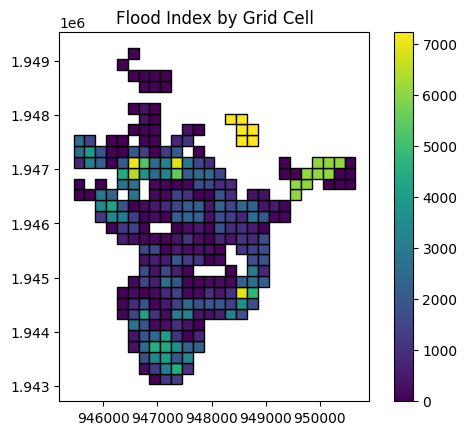

In [ ]:
# Ensure flood_ydp_ind is a GeoDataFrame with a geometry column
if not isinstance(flood_ydp_ind, gpd.GeoDataFrame):
    # Merge the flood index data with the grid data to include geometry
    flood_ydp_ind = grid.merge(flood_ydp_ind, on='grid_id') # flood_ydp_ind에 지오메트리 정보가 없어서 지오메트리 정보가 있는 grid와 병합한 것.

# Plot the flood_index
plt.figure(figsize=(10, 8))
flood_ydp_ind.plot(column='flood_index', cmap='viridis', legend=True, edgecolor='black')
plt.title('Flood Index by Grid Cell')
plt.show()

#빈 이유는 저기 사이가 하천이라서 그럼...

In [ ]:
flood_ydp_ind #geometry 정보가 들어간 것을 알 수 있다.

,geometry,grid_id,F_SHIM,F_AVR_HGT,F_AREA,F_TIME,flood_index
0,"POLYGON ((945654.346 1946429.538, 945654.346 1...",18,0.3,8.100000,62.00,4.0,5.216007
1,"POLYGON ((945654.346 1946629.538, 945654.346 1...",19,0.3,8.200000,354.00,4.0,53.342359
2,"POLYGON ((945654.346 1947029.538, 945654.346 1...",21,0.3,8.660000,5012.09,4.0,821.429378
3,"POLYGON ((945654.346 1947229.538, 945654.346 1...",22,0.3,8.559231,15390.17,4.0,2533.058378
4,"POLYGON ((945654.346 1947429.538, 945654.346 1...",23,0.3,8.410000,15378.30,4.0,2531.147784
...,...,...,...,...,...,...,...
284,"POLYGON ((950454.346 1946829.538, 950454.346 1...",764,0.3,13.380000,33.00,4.0,-1.231764
285,"POLYGON ((950454.346 1947029.538, 950454.346 1...",765,0.3,13.440000,36651.78,4.0,6038.074719
286,"POLYGON ((950654.346 1946629.538, 950654.346 1...",794,0.3,16.640000,33.00,4.0,-2.259755
287,"POLYGON ((950654.346 1946829.538, 950654.346 1...",795,0.3,13.380000,33.00,4.0,-1.231764


<ipython-input-18-8d109f3bd409>:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_geometry = target_boundary.unary_union


<Figure size 1000x800 with 0 Axes>

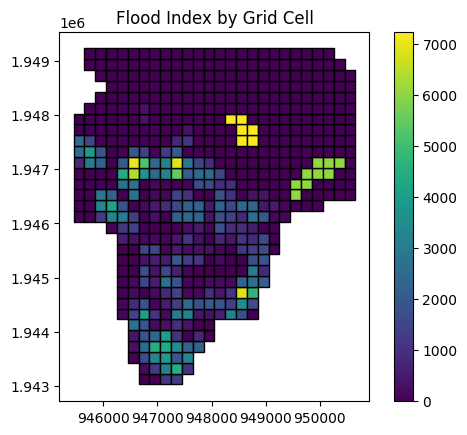

In [ ]:
boundary = gpd.read_file("/content/drive/MyDrive/공모전_시도/DAB 경영/LARD_ADM_SECT_SGG_서울/LARD_ADM_SECT_SGG_11_202405.shp")
# 좌표계 맞춰주기
boundary = boundary.to_crs(grid.crs)
# 4개 구에 해당하는 행들만 추출해서 공간을 합침
target_boundary = boundary[boundary['SGG_NM'].isin(['서울특별시 영등포구'])]
combined_geometry = target_boundary.unary_union
# combined_geometry를 GeoDataFrame으로 변환
if not isinstance(combined_geometry, gpd.GeoDataFrame):
    combined_geometry = gpd.GeoDataFrame(geometry=[combined_geometry], crs=grid.crs)

# 공간 조인을 사용하여 교차(intersects)하는 행만 선택
grid2 = gpd.sjoin(grid, combined_geometry, predicate='intersects')

# index_right 컬럼 drop
grid2 = grid2.drop(columns=['index_right'])
# grid2와 flood4를 병합하되 grid2를 기준으로 병합. flood4에 있었던 컬럼 중 빈 데이터가 있는 경우에는 빈 셀만 0으로 채움.

flood_grid2 = gpd.sjoin(grid2, flood_ydp, how="left", predicate="intersects")
flood_grid2 = flood_grid2.fillna(0)
# Calculate the flood index for each grid cell
flood_ind = flood_grid2.groupby('grid_id').agg(
    F_SHIM=('F_SHIM', 'mean'),
    F_AVR_HGT=('F_AVR_HGT', 'mean'),
    F_AREA=('F_AREA', 'sum'),
    F_TIME=('F_TIME', 'mean')
).reset_index()

flood_ind['flood_index'] = -(weights[0] * flood_ind['F_SHIM'] +
                                weights[1] * flood_ind['F_AVR_HGT'] +
                                weights[2] * flood_ind['F_AREA'] +
                                weights[3] * flood_ind['F_TIME'])
# Ensure flood_ind is a GeoDataFrame with a geometry column
if not isinstance(flood_ind, gpd.GeoDataFrame):
    # Merge the flood index data with the grid data to include geometry
    flood_ind = grid.merge(flood_ind, on='grid_id') # flood_ind에 지오메트리 정보가 없어서 지오메트리 정보가 있는 grid와 병합한 것.

# Plot the flood_index
plt.figure(figsize=(10, 8))
flood_ind.plot(column='flood_index', cmap='viridis', legend=True, edgecolor='black')
plt.title('Flood Index by Grid Cell')
plt.show()

# 영등포 grid 추출
영등포에 한정 그리드 추출

In [ ]:
grid_y = flood_ind[['geometry','grid_id']]

In [ ]:
grid_y

,geometry,grid_id
0,"POLYGON ((945654.346 1946029.538, 945654.346 1...",16
1,"POLYGON ((945654.346 1946229.538, 945654.346 1...",17
2,"POLYGON ((945654.346 1946429.538, 945654.346 1...",18
3,"POLYGON ((945654.346 1946629.538, 945654.346 1...",19
4,"POLYGON ((945654.346 1946829.538, 945654.346 1...",20
...,...,...
554,"POLYGON ((950654.346 1947829.538, 950654.346 1...",800
555,"POLYGON ((950654.346 1948029.538, 950654.346 1...",801
556,"POLYGON ((950654.346 1948229.538, 950654.346 1...",802
557,"POLYGON ((950654.346 1948429.538, 950654.346 1...",803


# 하천과의 거리

- grid를 영등포로 제한했음.

In [ ]:
# Load the river data and transform it to the same CRS as the grid
river = gpd.read_file("/content/drive/MyDrive/공모전_시도/DAB 경영/서울시 하천/uq156.shp")
river = river.to_crs(grid_y.crs) #river의 CRS를 grid의 CRS로 변환하여 두 데이터셋이 동일한 CRS를 사용
river.head(3)

,PRESENT_SN,LCLAS_CL,MLSFC_CL,SCLAS_CL,ATRB_SE,WTNNC_SN,NTFC_SN,DGM_NM,DGM_AR,DGM_LT,SIGNGU_SE,DRAWING_NO,EXCUT_SE,CREATE_DAT,SHAPE_AREA,SHAPE_LEN,geometry
0,11000UQ156PS201912150181,UQW100,UQW190,None,UQW190,11000URZ000000001561,None,하천,50.639219,228.653284,11000,None,EMA0009,2019-12-15,50.637039,228.653453,"POLYGON ((962087.934 1954693.705, 962091.582 1..."
1,11000UQ156PS201912150183,UQW100,UQW190,None,UQW190,11000URZ000000001561,None,하천,3.471594,62.522555,11000,None,EMA0009,2019-12-15,3.470806,62.522318,"POLYGON ((961990.072 1955176.986, 961989.53 19..."
2,11000UQ156PS201912150196,UQW100,UQW190,None,UQW190,11000URZ000000001561,None,하천,307.522834,105.254088,11000,None,EMA0009,2019-12-15,307.527947,105.254271,"POLYGON ((960904.64 1957676.217, 960899.983 19..."


In [ ]:
# Calculate the minimum distance from each grid cell to the river
river_grid = grid_y.copy()
river_grid['river_dist'] = river_grid.geometry.apply(lambda x: river.distance(x).min())

In [ ]:
river_grid

,geometry,grid_id,river_dist
0,"POLYGON ((945654.346 1946029.538, 945654.346 1...",16,0.000000
1,"POLYGON ((945654.346 1946229.538, 945654.346 1...",17,0.000000
2,"POLYGON ((945654.346 1946429.538, 945654.346 1...",18,3.915015
3,"POLYGON ((945654.346 1946629.538, 945654.346 1...",19,35.665071
4,"POLYGON ((945654.346 1946829.538, 945654.346 1...",20,55.158787
...,...,...,...
554,"POLYGON ((950654.346 1947829.538, 950654.346 1...",800,0.000000
555,"POLYGON ((950654.346 1948029.538, 950654.346 1...",801,0.000000
556,"POLYGON ((950654.346 1948229.538, 950654.346 1...",802,0.000000
557,"POLYGON ((950654.346 1948429.538, 950654.346 1...",803,0.000000


# 하천과의 거리 결과

<Figure size 1000x800 with 0 Axes>

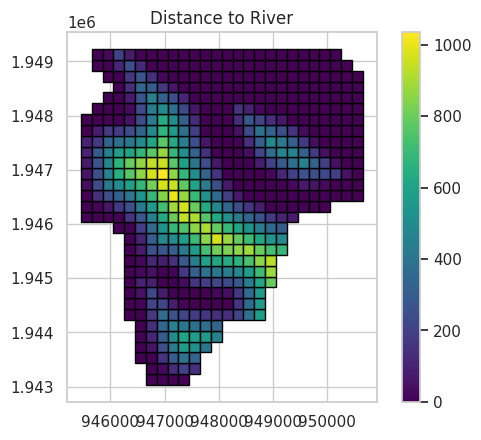

In [ ]:
# Visualization
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
river_grid.plot(column='river_dist', cmap='viridis', legend=True, edgecolor='black')
plt.title('Distance to River')
plt.show()

# 굿! 완성!!

# 영등포의 하수도 시설 현황; 빗물펌프장
- 하수도까지의 거리가 중요

In [ ]:
sewer = gpd.read_file("/content/drive/MyDrive/공모전_시도/DAB 경영/서울시 빗물 펌프장 공간정보_서울데이터열린광장_2022/RAINPUMP.shp", encoding='cp949')
sewer.crs = 'EPSG:5186'

In [ ]:
sewer = sewer.to_crs(grid_y.crs) #river의 CRS를 grid의 CRS로 변환하여 두 데이터셋이 동일한 CRS를 사용
sewer.head(3)

,OBJECTID,RV_CD,SP_CD,UNI_CD,IDX_NO,PUMP_NM,ETC,OPR_YN,EST_DT,geometry
0,6825,1005090,C02,1005090C020000000046,0000000046,신이문2,812,None,None,MULTIPOINT (961873.305 1955399.507)
1,6826,1000010,C02,1000010C020000001001,0000001001,옥수,903,None,None,MULTIPOINT (957405.161 1949215.015)
2,6827,1000010,C02,1000010C020000001002,0000001002,구의,1202,None,None,MULTIPOINT (964004.374 1948120.136)


In [ ]:
sewer_grid = grid_y.copy()
sewer_grid['sewer_dist']=sewer_grid.geometry.apply(lambda x: sewer.distance(x).min())
sewer_grid

,geometry,grid_id,sewer_dist
0,"POLYGON ((945654.346 1946029.538, 945654.346 1...",16,160.340316
1,"POLYGON ((945654.346 1946229.538, 945654.346 1...",17,0.000000
2,"POLYGON ((945654.346 1946429.538, 945654.346 1...",18,39.659684
3,"POLYGON ((945654.346 1946629.538, 945654.346 1...",19,239.659684
4,"POLYGON ((945654.346 1946829.538, 945654.346 1...",20,439.659684
...,...,...,...
554,"POLYGON ((950654.346 1947829.538, 950654.346 1...",800,808.883297
555,"POLYGON ((950654.346 1948029.538, 950654.346 1...",801,730.088768
556,"POLYGON ((950654.346 1948229.538, 950654.346 1...",802,547.685010
557,"POLYGON ((950654.346 1948429.538, 950654.346 1...",803,347.687260


<Figure size 1000x800 with 0 Axes>

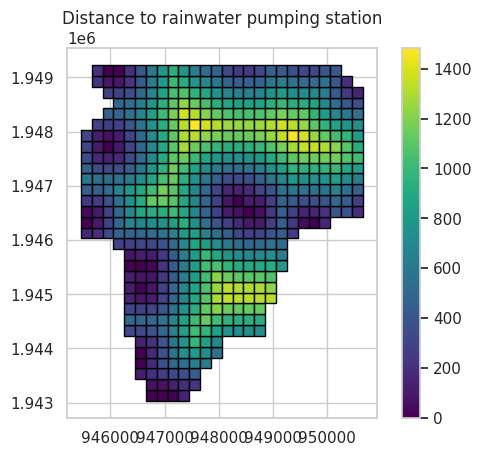

In [ ]:
# Visualization
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
sewer_grid.plot(column='sewer_dist', cmap='viridis', legend=True, edgecolor='black')
plt.title('Distance to rainwater pumping station')
plt.show()

# 굿! 완성!!

# 영등포 빗물관리시설 공간정보

In [ ]:
rmg = gpd.read_file("/content/drive/MyDrive/공모전_시도/DAB 경영/서울시 빗물관리시설 공간정보_서울데이터열린광장_2022/SP_IFEQ_PS.shp", encoding='cp949')
rmg.crs = 'EPSG:5186'
rmg = rmg.to_crs(grid_y.crs) #river의 CRS를 grid의 CRS로 변환하여 두 데이터셋이 동일한 CRS를 사용
rmg.head(3)

,OBJECTID,REGSTR_NO,MANAGE_NO,DEL_YN,geometry
0,5761,2,4.0,Y,MULTIPOINT (965053.906 1949560.589)
1,5762,20,62.0,Y,MULTIPOINT (958151.843 1961828.486)
2,5763,55,45.0,Y,MULTIPOINT (953579.401 1951625.619)


In [ ]:
rmg_grid = grid_y.copy()
rmg_grid['rmg_dist']=rmg_grid.geometry.apply(lambda x: rmg.distance(x).min())
rmg_grid

,geometry,grid_id,rmg_dist
0,"POLYGON ((945654.346 1946029.538, 945654.346 1...",16,3823.429043
1,"POLYGON ((945654.346 1946229.538, 945654.346 1...",17,3842.695977
2,"POLYGON ((945654.346 1946429.538, 945654.346 1...",18,3872.210622
3,"POLYGON ((945654.346 1946629.538, 945654.346 1...",19,3911.741023
4,"POLYGON ((945654.346 1946829.538, 945654.346 1...",20,3960.987321
...,...,...,...
554,"POLYGON ((950654.346 1947829.538, 950654.346 1...",800,2292.192252
555,"POLYGON ((950654.346 1948029.538, 950654.346 1...",801,2474.236861
556,"POLYGON ((950654.346 1948229.538, 950654.346 1...",802,2658.862684
557,"POLYGON ((950654.346 1948429.538, 950654.346 1...",803,2845.567342


<Figure size 1000x800 with 0 Axes>

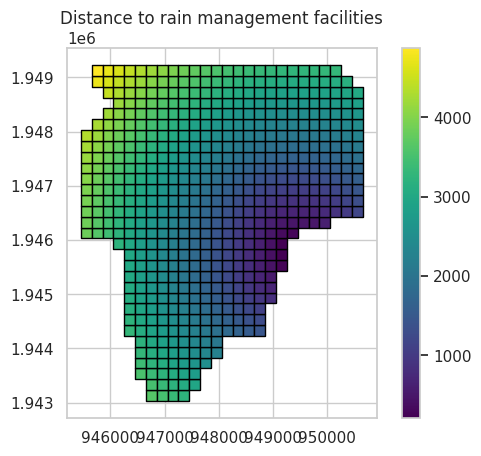

In [ ]:
# Visualization
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
rmg_grid.plot(column='rmg_dist', cmap='viridis', legend=True, edgecolor='black')
plt.title('Distance to rain management facilities')
plt.show()

# 불투수면 비율

In [ ]:
imsurf = pd.read_csv("/content/drive/MyDrive/공모전_시도/DAB 경영/서울특별시_자치구별 불투수면적 현황_20201231.csv",encoding='euc-kr')

In [ ]:
imsurf

,연번,자치구,구 전체면적(헥타르),불투수면적(헥타르),불투수면적 비율(퍼센트),비고
0,1,종로구,2312.4,971.6,42.02,
1,2,중구,998.2,749.2,75.05,
2,3,용산구,2196.7,970.0,44.16,
3,4,성동구,1642.2,1040.4,63.36,
4,5,광진구,1788.9,1023.9,57.23,
5,6,동대문구,1459.4,1078.3,73.89,
6,7,중랑구,1829.9,1070.6,58.51,
7,8,성북구,2487.1,1305.1,52.48,
8,9,강북구,2381.9,861.2,36.15,
9,10,도봉구,2077.7,839.8,40.42,


In [ ]:
imsurf_grid = grid_y.copy()
# '자치구'가 '영등포'인 데이터만 필터링
ydp_data = imsurf[imsurf['자치구'] == '영등포구']

# 필터링된 데이터에서 '불투수면적 비율(퍼센트)' 열만 선택
ydp_impervious_rate = ydp_data['불투수면적 비율(퍼센트)']
ydp_impervious_rate

,불투수면적 비율(퍼센트)
18,59.61


In [ ]:
# '영등포' 자치구에서 구한 '불투수면적 비율(퍼센트)' 값 중 하나를 사용
impervious_rate_value = ydp_impervious_rate.iloc[0]  # 첫 번째 값 사용 (또는 특정 값을 선택)

# imsurf_grid에 '불투수면적 비율(퍼센트)' 열을 추가하고, 동일한 값으로 채움
imsurf_grid['불투수면적 비율(퍼센트)'] = impervious_rate_value

In [ ]:
imsurf_grid

,geometry,grid_id,불투수면적 비율(퍼센트)
0,"POLYGON ((945654.346 1946029.538, 945654.346 1...",16,59.61
1,"POLYGON ((945654.346 1946229.538, 945654.346 1...",17,59.61
2,"POLYGON ((945654.346 1946429.538, 945654.346 1...",18,59.61
3,"POLYGON ((945654.346 1946629.538, 945654.346 1...",19,59.61
4,"POLYGON ((945654.346 1946829.538, 945654.346 1...",20,59.61
...,...,...,...
554,"POLYGON ((950654.346 1947829.538, 950654.346 1...",800,59.61
555,"POLYGON ((950654.346 1948029.538, 950654.346 1...",801,59.61
556,"POLYGON ((950654.346 1948229.538, 950654.346 1...",802,59.61
557,"POLYGON ((950654.346 1948429.538, 950654.346 1...",803,59.61


<Figure size 1000x800 with 0 Axes>

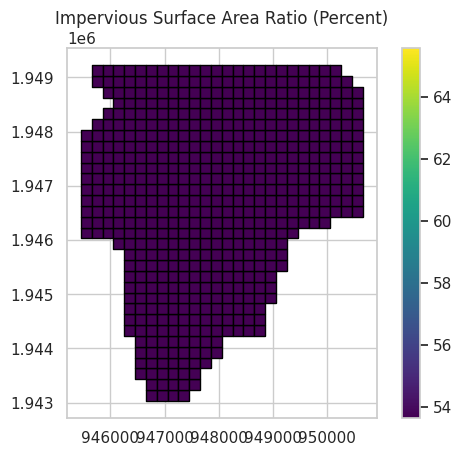

In [ ]:
# Visualization
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
imsurf_grid.plot(column='불투수면적 비율(퍼센트)', cmap='viridis', legend=True, edgecolor='black')
plt.title("Impervious Surface Area Ratio (Percent)")
plt.show()

# 영등포 고도_2022
-데이터
https://www.vworld.kr/dtmk/dtmk_ntads_s002.do?searchKeyword=%ED%86%A0%EC%A7%80&searchOrganization=&searchBrmCode=&searchTagList=&searchFrm=&pageIndex=1&gidmCd=&gidsCd=&sortType=00&svcCde=NA&dsId=4&listPageIndex=2


A19 : 표준지의 토지에 대한 높이(고저)를 표시하는 코드
0 : 지정되지 않음
1: 저지 2:평지 3: 완경사 4:급경사 5:고지

In [ ]:
elevation = gpd.read_file("/content/drive/MyDrive/공모전_시도/DAB 경영/영등포 (고도)토지특성공간정보_디지털트윈국토_2022/AL_11560_D194_20221115.shp", encoding='cp949')
elevation

,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A18,A19,A20,A21,A22,A23,A24,A25,A26,geometry
0,463832639,1156010100100000001,1156010100,서울특별시 영등포구 영등포동,1,일반,00000001,0-1 가,None,None,...,None,None,None,None,None,None,None,NaN,2022-11-08,"POLYGON ((191230.385 446720.33, 191230.916 446..."
1,463812111,1156010100100000008,1156010100,서울특별시 영등포구 영등포동,1,일반,00000008,0-8 가,None,None,...,None,None,None,None,None,None,None,NaN,2022-11-08,"POLYGON ((191236.547 446748.594, 191245.844 44..."
2,463804596,1156010100101730002,1156010100,서울특별시 영등포구 영등포동,1,일반,173-2,173-2철,2022,01,...,도로등,03,완경사,00,지정되지않음,01,광대로한면,3366000.0,2022-11-08,"POLYGON ((191194.261 446516.545, 191193.001 44..."
3,502637714,1156010100101730003,1156010100,서울특별시 영등포구 영등포동,1,일반,173-3,173-3 도,None,None,...,None,None,None,None,None,None,None,NaN,2022-11-08,"POLYGON ((191190.297 446492.875, 191190.031 44..."
4,502632836,1156010100101770003,1156010100,서울특별시 영등포구 영등포동,1,일반,177-3,177-3 도,None,None,...,None,None,None,None,None,None,None,NaN,2022-11-08,"POLYGON ((191190.297 446492.875, 191190.031 44..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37472,463814742,1156013400105020001,1156013400,서울특별시 영등포구 양평동,1,일반,502-1,502-1제,2022,01,...,도로등,00,지정되지않음,00,지정되지않음,00,지정되지않음,431000.0,2022-11-08,"POLYGON ((190006.048 448951.866, 190008.524 44..."
37473,463808580,1156013400105030000,1156013400,서울특별시 영등포구 양평동,1,일반,503,503도,2022,01,...,도로등,00,지정되지않음,00,지정되지않음,00,지정되지않음,431000.0,2022-11-08,"POLYGON ((190198.88 448573.347, 190200.419 448..."
37474,463808579,1156013400105030001,1156013400,서울특별시 영등포구 양평동,1,일반,503-1,503-1제,2022,01,...,도로등,00,지정되지않음,00,지정되지않음,00,지정되지않음,431000.0,2022-11-08,"POLYGON ((190175.756 448573.375, 190180.715 44..."
37475,463809000,1156013400105040000,1156013400,서울특별시 영등포구 양평동,1,일반,504,504도,2022,01,...,도로등,00,지정되지않음,00,지정되지않음,00,지정되지않음,431000.0,2022-11-08,"POLYGON ((190316.968 448209.525, 190342.715 44..."


In [ ]:
elevation = gpd.read_file("/content/drive/MyDrive/공모전_시도/DAB 경영/영등포 (고도)토지특성공간정보_디지털트윈국토_2022/AL_11560_D194_20221115.shp", encoding='cp949')
#elevation.crs = 'EPSG:5186'
elevation = elevation.to_crs(grid_y.crs) #river의 CRS를 grid의 CRS로 변환하여 두 데이터셋이 동일한 CRS를 사용
elevation.head(3)

,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A18,A19,A20,A21,A22,A23,A24,A25,A26,geometry
0,463832639,1156010100100000001,1156010100,서울특별시 영등포구 영등포동,1,일반,00000001,0-1 가,None,None,...,None,None,None,None,None,None,None,NaN,2022-11-08,"POLYGON ((947121.704 1947210.27, 947122.246 19..."
1,463812111,1156010100100000008,1156010100,서울특별시 영등포구 영등포동,1,일반,00000008,0-8 가,None,None,...,None,None,None,None,None,None,None,NaN,2022-11-08,"POLYGON ((947128.014 1947238.491, 947137.292 1..."
2,463804596,1156010100101730002,1156010100,서울특별시 영등포구 영등포동,1,일반,173-2,173-2철,2022,01,...,도로등,03,완경사,00,지정되지않음,01,광대로한면,3366000.0,2022-11-08,"POLYGON ((947084.515 1947006.756, 947083.218 1..."


In [ ]:
elevation_grid = grid_y.copy()
elevation_grid['elevation']=elevation['A19']
elevation_grid

,geometry,grid_id,elevation
0,"POLYGON ((945654.346 1946029.538, 945654.346 1...",16,None
1,"POLYGON ((945654.346 1946229.538, 945654.346 1...",17,None
2,"POLYGON ((945654.346 1946429.538, 945654.346 1...",18,03
3,"POLYGON ((945654.346 1946629.538, 945654.346 1...",19,None
4,"POLYGON ((945654.346 1946829.538, 945654.346 1...",20,None
...,...,...,...
554,"POLYGON ((950654.346 1947829.538, 950654.346 1...",800,00
555,"POLYGON ((950654.346 1948029.538, 950654.346 1...",801,02
556,"POLYGON ((950654.346 1948229.538, 950654.346 1...",802,02
557,"POLYGON ((950654.346 1948429.538, 950654.346 1...",803,02


# 영등포 고도 결과_2022
A19 : 표준지의 토지에 대한 높이(고저)를 표시하는 코드 0 : 지정되지 않음 1: 저지 2:평지 3: 완경사 4:급경사 5:고지

<Figure size 1000x800 with 0 Axes>

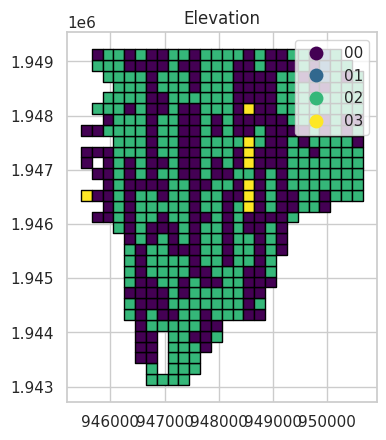

In [ ]:
# Visualization
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
elevation_grid.plot(column='elevation', cmap='viridis', legend=True, edgecolor='black')
plt.title('Elevation')
plt.show()



# 영등포 고도 결측치채워서 다시 함.

In [ ]:
gdf = elevation_grid

In [ ]:
# 결측치가 있는 'elevation' 열의 불리언 배열 생성
is_missing = gdf['elevation'].isna()

# 불리언 배열을 사용하여 결측치가 있는 행 필터링
missing_values = gdf[is_missing]

# 결측치가 있는 행의 인덱스 확인
missing_idx = missing_values.index

In [ ]:
from scipy.spatial import cKDTree

In [ ]:
from collections import Counter


In [ ]:
# 4. 모든 폴리곤의 좌표를 얻기
coords = np.array([poly.centroid.coords[0] for poly in gdf.geometry])

# 5. KDTree를 생성하여 인접 폴리곤 찾기
tree = cKDTree(coords)

def get_most_frequent_value(point):
    # 결측치가 있는 폴리곤의 중심 좌표
    dist, neighbors = tree.query(point, k=10)  # k는 근처 폴리곤의 수
    neighbor_values = gdf.iloc[neighbors]['elevation']
    # 가장 빈번한 값 찾기
    if neighbor_values.notna().any():  # Ensure there are non-NaN values
        most_common_value = Counter(neighbor_values.dropna()).most_common(1)[0][0]
        return most_common_value
    else:
        return np.nan  # Return np.nan if no valid values are found

# 결측치가 있는 각 폴리곤에 대해 값을 채우기
for idx in missing_values.index:
    point = gdf.geometry.iloc[idx].centroid.coords[0]
    most_common_value = get_most_frequent_value(point)
    if not pd.isna(most_common_value):  # Ensure value is not NaN before assignment
        gdf.at[idx, 'elevation'] = most_common_value

<Figure size 1000x800 with 0 Axes>

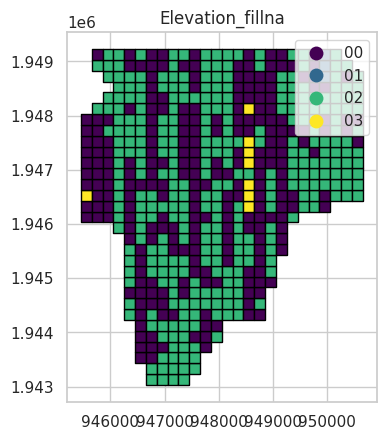

In [ ]:
# Visualization
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
gdf.plot(column='elevation', cmap='viridis', legend=True, edgecolor='black')
plt.title('Elevation_fillna')
plt.show()


# 강우량 - 근접한 강우량계에서 가져옴

In [ ]:
rain_grid = grid_y.copy()

In [ ]:
rain = pd.read_csv("/content/drive/MyDrive/공모전_시도/DAB 경영/서울시 강수량 2022/서울시_강우량_정보_2022년08월.csv", encoding='CP949')
rain.crs = 'EPSG:5181'

In [ ]:
loc = gpd.read_file("/content/drive/MyDrive/공모전_시도/DAB 경영/서울시 강우량계 공간정보/seoul_rain.shp",encoding='CP949')

In [ ]:
loc = loc.iloc[:, [12, 13]]
loc.columns = ["강우량계 코드", "geometry"]

In [ ]:
# rain 데이터를 강우량계 코드로 병합
rain_loc = pd.merge(rain, loc, on="강우량계 코드")

In [ ]:
# guname 컬럼 이름 변경 및 영등포구 필터링
rain_loc.columns = ["강우량계 코드", "강우량계명", "구청 코드", "guname", "rain_10min", "자료수집 시각", "geometry"]

In [ ]:
rain_loc

,강우량계 코드,강우량계명,구청 코드,guname,rain_10min,자료수집 시각,geometry
0,802,휘경P,108,동대문구,0.0,2022-08-01 00:09,POINT (206108.7 454636.1)
1,301,도봉구청,103,도봉구,0.0,2022-08-01 00:09,POINT (204155.4 463229.6)
2,2102,흑석P,121,동작구,0.0,2022-08-01 00:09,POINT (196771.2 445552.7)
3,1901,영등포구청,119,영등포구,0.5,2022-08-01 00:09,POINT (190802.8 447424.1)
4,2002,개봉2동,120,구로구,0.5,2022-08-01 00:09,POINT (187316.8 443495.4)
...,...,...,...,...,...,...,...
208025,1303,갈현1동,113,은평구,0.0,2022-08-31 23:59,POINT (192650 458233.8)
208026,1602,한남P,116,용산구,0.0,2022-08-31 23:59,POINT (200682.1 447743.9)
208027,2302,신림P,123,관악구,0.0,2022-08-31 23:59,POINT (191887.1 442818.4)
208028,1201,광진구청,112,광진구,0.0,2022-08-31 23:59,POINT (207286.8 448771.4)


In [ ]:
# rain 데이터를 GeoDataFrame으로 변환
rain_loc = gpd.GeoDataFrame(rain_loc, geometry='geometry', crs='EPSG:5181')

In [ ]:
# 좌표 변환 및 격자와 공간 조인
rain_loc = rain_loc.to_crs(grid_y.crs)

In [ ]:
rain_loc

,강우량계 코드,강우량계명,구청 코드,guname,rain_10min,자료수집 시각,geometry
0,802,휘경P,108,동대문구,0.0,2022-08-01 00:09,POINT (961964.974 1954739.232)
1,301,도봉구청,103,도봉구,0.0,2022-08-01 00:09,POINT (960058.218 1963339.735)
2,2102,흑석P,121,동작구,0.0,2022-08-01 00:09,POINT (952582.839 1945709.034)
3,1901,영등포구청,119,영등포구,0.5,2022-08-01 00:09,POINT (946626.669 1947611.425)
4,2002,개봉2동,120,구로구,0.5,2022-08-01 00:09,POINT (943121.119 1943702.727)
...,...,...,...,...,...,...,...
208025,1303,갈현1동,113,은평구,0.0,2022-08-31 23:59,POINT (948530.669 1958407.178)
208026,1602,한남P,116,용산구,0.0,2022-08-31 23:59,POINT (956503.861 1947878.604)
208027,2302,신림P,123,관악구,0.0,2022-08-31 23:59,POINT (947686.094 1943001.719)
208028,1201,광진구청,112,광진구,0.0,2022-08-31 23:59,POINT (963111.416 1948870.598)


In [ ]:
# # 커스텀 집계 함수 정의
# def divide_by_31(series):
#     return series.sum() / 31

In [ ]:
# 데이터 그룹화 및 집계
result = rain_loc.groupby('강우량계 코드').agg({
    'rain_10min': 'sum',
    'geometry': 'first',  # 그룹 내 첫 번째 값을 남깁니다.
    'guname': 'first',    # 그룹 내 첫 번째 값을 남깁니다.
    '강우량계명': 'first'  # 그룹 내 첫 번째 값을 남깁니다.
}).reset_index()

In [ ]:
result

,강우량계 코드,rain_10min,geometry,guname,강우량계명
0,101,705.0,POINT (960011.632 1946571.628),강남구,강남구청
1,102,793.5,POINT (965250.184 1941168.088),강남구,세곡동
2,103,701.5,POINT (961828.834 1943480.406),강남구,개포2동
3,201,651.5,POINT (966750.869 1947931.59),강동구,강동구청
4,202,576.0,POINT (970358.416 1951296.933),강동구,고덕2동
5,301,576.5,POINT (960058.218 1963339.735),도봉구,도봉구청
6,401,557.0,POINT (960893.784 1961722.371),노원구,노원구청
7,402,531.5,POINT (960750.643 1964572.888),노원구,상계1동
8,501,492.0,POINT (958134.516 1960113.773),강북구,강북구청
9,601,550.0,POINT (957688.657 1954329.155),성북구,성북구청


In [ ]:
rain_loc = result

In [ ]:
# 각 Polygon의 중심점(centroid)을 구해서 새로운 열에 저장
rain_grid['centroid'] = rain_grid['geometry'].centroid

In [ ]:
rain_grid

,geometry,grid_id,centroid
0,"POLYGON ((945654.346 1946029.538, 945654.346 1...",16,POINT (945554.346 1946129.538)
1,"POLYGON ((945654.346 1946229.538, 945654.346 1...",17,POINT (945554.346 1946329.538)
2,"POLYGON ((945654.346 1946429.538, 945654.346 1...",18,POINT (945554.346 1946529.538)
3,"POLYGON ((945654.346 1946629.538, 945654.346 1...",19,POINT (945554.346 1946729.538)
4,"POLYGON ((945654.346 1946829.538, 945654.346 1...",20,POINT (945554.346 1946929.538)
...,...,...,...
554,"POLYGON ((950654.346 1947829.538, 950654.346 1...",800,POINT (950554.346 1947929.538)
555,"POLYGON ((950654.346 1948029.538, 950654.346 1...",801,POINT (950554.346 1948129.538)
556,"POLYGON ((950654.346 1948229.538, 950654.346 1...",802,POINT (950554.346 1948329.538)
557,"POLYGON ((950654.346 1948429.538, 950654.346 1...",803,POINT (950554.346 1948529.538)


In [ ]:
# rain_loc의 point 좌표를 추출하여 KDTree 생성
loc_points = np.array(list(rain_loc['geometry'].apply(lambda x: (x.x, x.y))))
tree = cKDTree(loc_points)

# rain_grid의 centroid 좌표를 추출하여 최근접 이웃 찾기
grid_centroids = np.array(list(rain_grid['centroid'].apply(lambda x: (x.x, x.y))))
distances, indices = tree.query(grid_centroids, k=1)

# 최근접 이웃으로부터 rain_loc의 rain_10min 값을 가져와 rain_grid에 새 열로 추가
rain_grid['rain_day'] = rain_loc.iloc[indices]['rain_10min'].values

# 필요 없는 centroid 열 삭제 (선택 사항)
rain_grid = rain_grid.drop(columns=['centroid'])

In [ ]:
rain_grid

,geometry,grid_id,rain_day
0,"POLYGON ((945654.346 1946029.538, 945654.346 1...",16,639.0
1,"POLYGON ((945654.346 1946229.538, 945654.346 1...",17,639.0
2,"POLYGON ((945654.346 1946429.538, 945654.346 1...",18,553.5
3,"POLYGON ((945654.346 1946629.538, 945654.346 1...",19,553.5
4,"POLYGON ((945654.346 1946829.538, 945654.346 1...",20,553.5
...,...,...,...
554,"POLYGON ((950654.346 1947829.538, 950654.346 1...",800,539.0
555,"POLYGON ((950654.346 1948029.538, 950654.346 1...",801,539.0
556,"POLYGON ((950654.346 1948229.538, 950654.346 1...",802,539.0
557,"POLYGON ((950654.346 1948429.538, 950654.346 1...",803,539.0


In [ ]:
rain_grid['rain_day'].unique()

array([639. , 553.5, 591. , 718.5, 741. , 539. , 583.5])

In [ ]:

# 각 unique 값의 개수 계산
unique_counts = rain_grid['rain_day'].value_counts()

In [ ]:
unique_counts

,count
rain_day,
591.0,170
639.0,130
583.5,93
539.0,90
741.0,42
553.5,18
718.5,16


# 강우량 지도 - 근접한 강우량계에서 가져옴

<Figure size 1000x800 with 0 Axes>

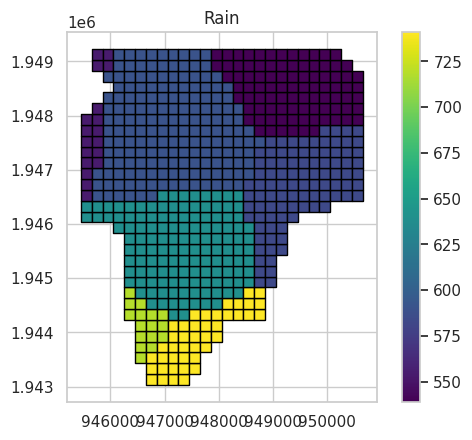

In [ ]:
# Visualization
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
rain_grid.plot(column='rain_day', cmap='viridis', legend=True, edgecolor='black')
plt.title('Rain')
plt.show()

# 경사도 데이터

In [ ]:
slope_grid = grid_y.copy()

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

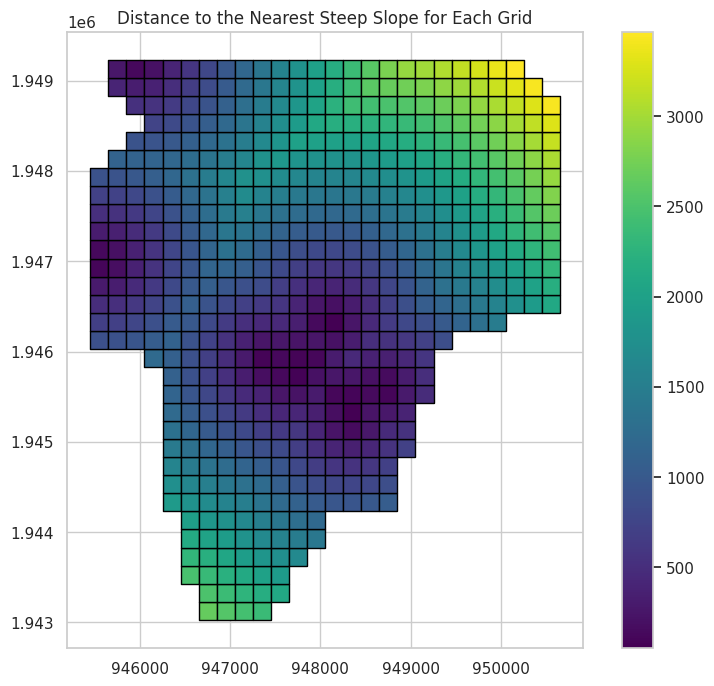

In [ ]:
# 경사도 데이터 불러오기
slope = pd.read_excel("/content/drive/MyDrive/공모전_시도/DAB 경영/경사지.xlsx")
slope['geometry'] = slope.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
slope_gdf = gpd.GeoDataFrame(slope, geometry='geometry', crs='EPSG:4326')
slope_gdf = slope_gdf.to_crs(grid_y.crs)

# 격자 중심점 계산
slope_grid['centroid'] = slope_grid['geometry'].centroid

# 격자 중심점과 경사도 지점 간의 최근접 이웃 계산
tree = cKDTree(np.array(list(slope_gdf['geometry'].apply(lambda x: (x.x, x.y)))))
distances, indices = tree.query(np.array(list(slope_grid['centroid'].apply(lambda x: (x.x, x.y)))), k=1)

# 거리를 데이터프레임에 추가
slope_grid['slope_dist'] = distances

# 결과 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
slope_grid.plot(column='slope_dist', ax=ax, legend=True, cmap='viridis', edgecolor='black')
# slope_gdf.plot(ax=ax, color='red', markersize=10)
plt.title("Distance to the Nearest Steep Slope for Each Grid")
plt.show()

# merge

In [ ]:
df = pd.merge(gdf, river_grid, on="geometry")
df = pd.merge(df, rmg_grid, on="geometry")

In [ ]:
df2 = df.iloc[:, [0,2,4,6]]
df = pd.merge(df2,flood_ind, on="geometry" )
df = df.iloc[:,[0,1,2,3,9]]
df = pd.merge(df,sewer_grid, on="geometry" )

In [ ]:
df = pd.merge(df,rain_grid, on="geometry" )
df = pd.merge(df,slope_grid, on="geometry" )
df = df.iloc[:,[0,1,2,3,4,6,8,11]]
df.rename(columns={'rain_day': 'rain_8'}, inplace=True)
df = pd.merge(df,imsurf_grid, on="geometry" )

In [ ]:
df #sewer_dist : 빗물펌프장까지의 거리, rmg_dist : 빗물관리 시설, 불투수면 비율은 구별로 나와서 뺌, river_dist : 하천과의 거리, elvation: 고도, flood_index : 침수 파생변수, #rain_8: 8월 강우량, #slope_dist : 경사지

,geometry,elevation,river_dist,rmg_dist,flood_index,sewer_dist,rain_8,slope_dist,grid_id,불투수면적 비율(퍼센트)
0,"POLYGON ((945654.346 1946029.538, 945654.346 1...",00,0.000000,3823.429043,-0.000000,160.340316,639.0,888.603904,16,59.61
1,"POLYGON ((945654.346 1946229.538, 945654.346 1...",00,0.000000,3842.695977,-0.000000,0.000000,639.0,688.965983,17,59.61
2,"POLYGON ((945654.346 1946429.538, 945654.346 1...",03,3.915015,3872.210622,5.216007,39.659684,553.5,489.623685,18,59.61
3,"POLYGON ((945654.346 1946629.538, 945654.346 1...",00,35.665071,3911.741023,53.342359,239.659684,553.5,291.184786,19,59.61
4,"POLYGON ((945654.346 1946829.538, 945654.346 1...",00,55.158787,3960.987321,-0.000000,439.659684,553.5,99.226039,20,59.61
...,...,...,...,...,...,...,...,...,...,...
554,"POLYGON ((950654.346 1947829.538, 950654.346 1...",00,0.000000,2292.192252,-0.000000,808.883297,539.0,2925.329598,800,59.61
555,"POLYGON ((950654.346 1948029.538, 950654.346 1...",02,0.000000,2474.236861,-0.000000,730.088768,539.0,3038.885895,801,59.61
556,"POLYGON ((950654.346 1948229.538, 950654.346 1...",02,0.000000,2658.862684,-0.000000,547.685010,539.0,3161.028584,802,59.61
557,"POLYGON ((950654.346 1948429.538, 950654.346 1...",02,0.000000,2845.567342,-0.000000,347.687260,539.0,3290.801716,803,59.61


In [ ]:
df.to_csv('/content/drive/MyDrive/공모전_시도/DAB 경영/침수팀_영등포.csv', index=False)  # index=False는 인덱스 제외 옵션